In [127]:
import joblib
import matplotlib.pyplot as plt
from training_data.Training_Data_Class import training_dataset
from Social_Dataset_Class import social_dataset
import numpy as np
from scipy.interpolate import interp1d
import pdb
from tqdm import tqdm 


# We want to fix long confusions by leveraging the continuous segment structure of the data: 

In [128]:
path = '../../Downloads/V118_03182018_cohousing-Camera-1-Animal-1-Segment1cropped_part'
# scorer0 = 'DeepCut_resnet50_social_v4Feb10shuffle1_100000.h5'
# scorer1 = 'DeepCut_resnet50_social_v4Feb10shuffle1_150000.h5'
groundtruth = training_dataset('training_data/CollectedData_Taiga.h5','training_data/')
vstats,mstats = [groundtruth.stats_wholemouse([i+1 for i in range(100)],m) for m in range(2)]
## Take a sample dataset where you know there are long confusion periods: 
# doi = social_dataset(path+'28'+scorer1)
data = joblib.load('all_data_smoothed_2_26')
data[29].import_movie(path+'29.mp4')
data[19].import_movie(path+'19.mp4')

(36000, 2)
(1200.0, 30.0)


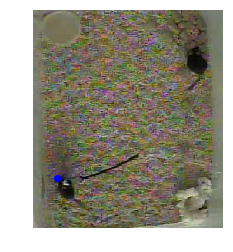

In [106]:
data[29].plot_image([0],18000)
plt.show()

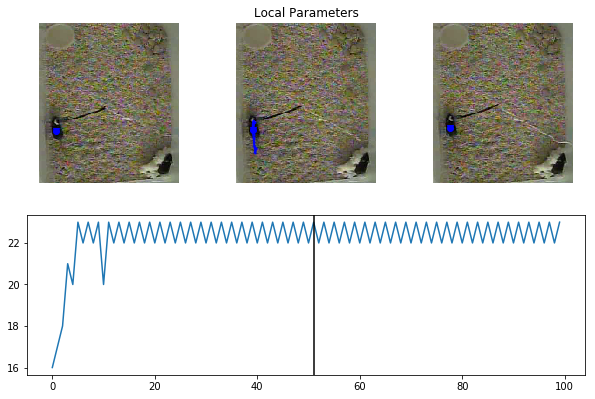

In [34]:
data[29].filter_check_image(6404,3,45,25)

3307


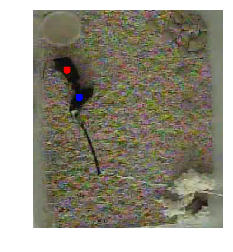

In [114]:
point = np.where(data[29].shepherding_ethogram())[0][13]
print(point)
data[29].plot_image_compare([3,8],point)

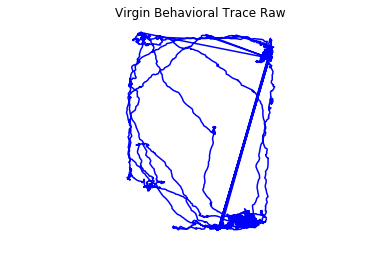

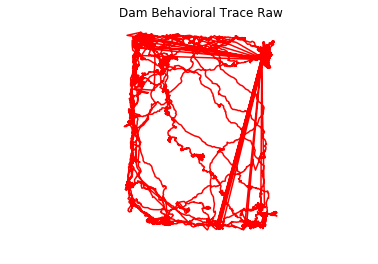

In [138]:
## reset filters: 
doi = data[13]
# doi.reset_filters([i for i in range(10)])
trajectories = doi.render_trajectories([3,8])
plt.title('Virgin Behavioral Trace Raw')
plt.plot(*np.split(trajectories[0],2,axis = 1),**{'color':'blue'})
plt.axis('equal')
plt.axis('off')
plt.show()
plt.title('Dam Behavioral Trace Raw')
plt.plot(*np.split(trajectories[1],2,axis = 1),**{'color':'red'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
data[13]

## Look at the variance in the speeds here: 

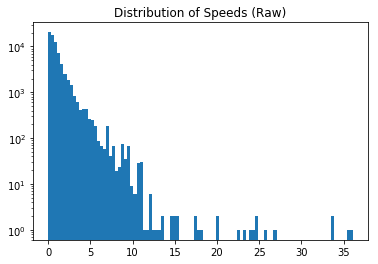

In [133]:
def speed_hists(title,trajectories):
    all_diffs = [np.linalg.norm(np.diff(trajectories[i],axis = 0),axis = 1) for i in range(len(trajectories))]
    # Filter for nans:
    all_diffs_filter =  [diff[np.where(~np.isnan(diff[:]))] for diff in all_diffs]
    plt.hist(np.concatenate(all_diffs_filter),bins = 100,log = True)
    plt.title(title)
    plt.show()

speed_hists('Distribution of Speeds (Raw)',trajectories)
# diffs0 = np.linalg.norm(np.diff(trajectories[0]),axis = 1)
# diffs1 = np.linalg.norm(np.diff(trajectories[1]),axis = 1)
# plt.hist(np.concatenate((diffs0,diffs1)),bins = 100)
# plt.title('Distribution of Speeds (Raw)')
# plt.show()

In [134]:
## Look at the distribtuion of speeds within segments: 
## Load the filtered dataset again: 
# doi.reset_filters([0,3,5,8])
# doi.filter_check_replaces_v2([0,3,5,8],varthresh = 35,skip = 2)
# doi.filter_crosscheck_replaces_v2([0,1,2,3,4,5,6,7,8,9],vstats,mstats,thresh = [2,2])

In [135]:
## Given a set of allowed indices, find all contiguous segments:
## Returns list of lists containing start and end points for each index (same index twice for singlets)
def find_segments(indices):
    differences = np.diff(indices)
    all_intervals = []
    ## Initialize with the first element added:
    interval = []
    interval.append(indices[0])
    for i,diff in enumerate(differences):
        if diff == 1:
            pass # interval not yet over
        else:
            # last interval ended
            if interval[0] == indices[i]:
                interval.append(indices[i]+1)
            else:
                interval.append(indices[i])
            all_intervals.append(interval)
            # start new interval
            interval = [indices[i+1]]
        if i == len(differences)-1:
            interval.append(indices[-1])
            all_intervals.append(interval)
    return all_intervals

# a = np.concatenate((np.arange(10),np.arange(1)+100,np.arange(10)+103))
# find_segments(a)


In [136]:
vsnout = doi.allowed_index_full[3][:,0]
msnout = doi.allowed_index_full[8][:,0]

v_segs = find_segments(vsnout)
m_segs = find_segments(msnout)


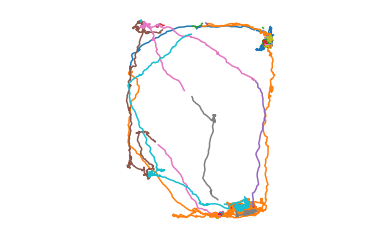

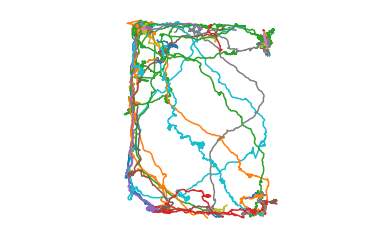

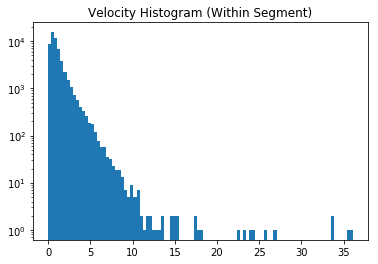

In [137]:
## Now calculate within-segment behavior and distribution of velocity:
segs = [v_segs,m_segs]
# print(segs)
all_vels = []
for segnb,segments in enumerate(segs):
    for seg in segments:
        trajseg = trajectories[segnb][seg[0]:seg[1],:]
        plt.plot(*np.split(trajseg,2,axis = 1))
        segvels = np.linalg.norm(np.diff(trajseg,axis = 0),axis = 1)
        all_vels.append(segvels)
    plt.axis('equal')
    plt.axis('off')
    
    plt.show()
plt.hist(np.concatenate(all_vels),bins = 100,log = True)
plt.title('Velocity Histogram (Within Segment)')

plt.show()

# This is great!!!!!!!!!! Now we can treat each segment as a behavioral unit, and ask about how well they all stitch together. 


In [77]:
## We want a function that searches through time. Every time that it finds a new segment in either the virgin or the dam
## decide if you want to assign it to: 1) itself. 2) nest. 3) the other 4) none of the above. This is decided with an 
## Interpolation window based on the previous self based trajectories and the whole future. 

## Helper function to return a segment given relevant information. Handles corner cases:
def segment_getter(trajectories,segs,segind,mouseind):
    ## If segind is negative, return the first element of the trajectory:
    if segind <0:
        segment = trajectories[mouseind][0:1,:]
        return segment
    else:
        segbounds = segs[mouseind][segind]
        segment = trajectories[mouseind][segbounds[0]:segbounds[1]]
        return segment
    
## Ty to streamline:


## The input consists of two segment sets and the trajectory data.:
def classify_v3(vsegs,msegs,trajectories):
    length = len(trajectories[0])
    ## Have a state variable for both animals that says if we are in a trajectory or not, and which we are in
    segs = [vsegs,msegs]
    vsegind = 0
    msegind = 0
    seginds = np.array([vsegind,msegind])
    vstart,vend = vsegs[vsegind][0],vsegs[vsegind][-1]
    mstart,mend = msegs[msegind][0],msegs[msegind][-1]
    
    starts = np.array([vstart,mstart])
    ends = np.array([vend,mend])
    labels = ['virgin','dam']
    
    ## Initialize a shell array of nans:
    shell_array = np.empty((36000,4))
    shell_array[:] = np.nan
    
    ## Initialize an array to keep track of when we're in the nest: 
    nest_array = np.zeros(36000,)
    
    for time in tqdm(range(length)):

        ## until we exit the current interval, we track the start and end of the current interval:
        timevec = np.repeat(time,2)
        ## If we exit the segment: 
        if np.any(timevec == ends):
            
            exits = np.where(timevec == ends)[0]

            for exit_ind in exits:
    
                starts[exit_ind] = segs[exit_ind][seginds[exit_ind]][0]
                ends[exit_ind] = segs[exit_ind][seginds[exit_ind]][-1]
  
        ## If we enter the next registered segment:
        if np.any(timevec == starts):

            enters = np.where(timevec == starts)[0]
            
            for enter_ind in enters:
                ## Define a start and end for this trajectory:
                selfstart,selfend = segs[enter_ind][seginds[enter_ind]][0],segs[enter_ind][seginds[enter_ind]][-1]
                otherstart,otherend = segs[1-enter_ind][seginds[1-enter_ind]][0],segs[1-enter_ind][seginds[1-enter_ind]][-1]
                
                ## Grab the trajectory:
                segment = segment_getter(trajectories,segs,seginds[enter_ind],enter_ind)

                ## First compare to your own past:

                # Find difference with past trajectory:
                # Find last end: 
                shell_column = shell_array[:,0+enter_ind*2:2+enter_ind*2]
                if np.all(np.isnan(shell_column)):
                    last_entry = segment[0:1,:]
                else:
                    last_entry_inds = np.where(~np.isnan(shell_column[:,0]))[0][-1:]
                    last_entry = shell_column[last_entry_inds,:]
              
                histselfdifference = np.linalg.norm(last_entry-segment[0,:])
            
                print(last_entry,time)
                threshbound = 100
                if histselfdifference < threshbound: 
                    ###################################################################
                    shell_array[selfstart:selfend,0+enter_ind*2:2+enter_ind*2] = segment
                    ###################################################################
                # If it doesnt fit with the past, compare to mirroring trajectory:
                else:

                    ## find indices that overlap with mirroring trajectory: 
                    maxstart,minend = np.max(starts),np.min(ends)
                   
                    if minend-maxstart <=0:
                        pass ## If other trajectory not valid at the time
                    else:
                        self = trajectories[enter_ind][maxstart:minend,:]
                        other = trajectories[1-enter_ind][maxstart:minend,:]

                        # Find difference with other trajectory
                        maxdifference = np.max(np.linalg.norm(self-other,axis = 1))
                        histotherdifference = np.linalg.norm(last_entry-other[0,:])


                        ## Three cases here:
                        ## 1) Trajectory duplicates an already existing other trajectory:
                        if histselfdifference > 3*maxdifference:
                            print(time,'passed')
                            pass ## We do not assign this segment to anyone, as it is already accounted for. 
                        ## 2) Trajectory has switched with the other trajectory:
                        elif histselfdifference > 3*histotherdifference:
                            print(time,'switched')
                            ###################################################################
                            shell_array[maxstart:minend,0+enter_ind*2:2+enter_ind*2] = other
                            shell_array[maxstart:minend,0+(1-enter_ind)*2:2+(1-enter_ind)*2] = self
                            ###################################################################
                        ## 3) Everything is fine. 
                        else:
                            ## Measure backwards from the current segment:
                            delay_interval = selfstart-last_entry_inds

                            if delay_interval > 30:
                                ###################################################################
                                shell_array[selfstart:selfend,0+enter_ind*2:2+enter_ind*2] = segment
                                ###################################################################
                            else:
                                plt.plot(np.arange(minend-maxstart)+maxstart,self,'ro',label = labels[enter_ind])
                                plt.plot(np.arange(minend-maxstart)+maxstart,other,'bo',label = labels[1-enter_ind])
                                plt.plot(np.ones((1,2))*maxstart,last_entry,'g*',markersize = 5)
                                plt.legend()
                                plt.show()

            ## We only want this to update if we're not at the last trajectory:
                if seginds[enter_ind]!= len(segs[enter_ind])-1:
                    seginds[enter_ind] += 1
#         if time == length -1:


#             fig,ax = plt.subplots(2,1)
#             ax[0].plot(shell_array[:,0:1],label = 'virginx')
#             ax[0].plot(shell_array[:,2:3],label = 'damx')
#             ax[1].plot(shell_array[:,1:2],label = 'virginy')
#             ax[1].plot(shell_array[:,3:4],label = 'damy')
#             ax[0].legend()
#             ax[1].legend()                        
#             plt.show()

    return shell_array

In [78]:
# ### Classify outputs into refine: 
# ## Look at our reliable data, and see if there is unreliable data that belongs there:
# def refine(processed_trajectories,trajectories):
    
                
        

In [79]:
# classify_v2(v_segs,m_segs,trajectories)

In [80]:
out_array = classify_v3(v_segs,m_segs,trajectories)

 15%|█▌        | 5413/36000 [00:00<00:01, 27212.75it/s]

(array([[294.75332808, 329.49893665]]), 0)
(array([[ 54.73124886, 128.89689398]]), 0)
(array([[ 57.35486507, 354.39937186]]), 1639)
(array([[ 44.92907381, 250.89674294]]), 3775)
(array([[ 43.04203844, 278.0244565 ]]), 3786)
(array([[112.52856636, 360.18904209]]), 3914)
(array([[111.62274361, 360.46427774]]), 3932)
(array([[111.33737135, 361.02160358]]), 3937)
(array([[111.65905952, 360.37140536]]), 3995)
(array([[112.52731156, 360.80108619]]), 4263)
(array([[112.88095617, 360.1448729 ]]), 4287)
(array([[113.23519373, 360.71944189]]), 4295)
(array([[111.52896881, 362.43114626]]), 4299)
(array([[111.91782236, 361.52699399]]), 4301)
(array([[113.51705766, 359.76490164]]), 4303)
(array([[112.59702516, 360.50224447]]), 4305)
(array([[112.6378336 , 360.60564113]]), 4308)
(array([[106.89001393, 356.75386608]]), 4311)
(array([[106.7946105 , 357.05198574]]), 4325)
(array([[111.78451538, 362.86166704]]), 4329)
(array([[112.49761462, 360.32133007]]), 4347)
(array([[112.95528221, 359.92269373]]), 

 31%|███▏      | 11292/36000 [00:00<00:00, 27563.76it/s]

(array([[265.79189396,  27.5365901 ]]), 9912)
(array([[265.75379276,  27.54159927]]), 9915)
(array([[265.37601614,  27.45966434]]), 9925)
(array([[203.99127046,  13.09830618]]), 9925)
(array([[269.7309593 , 255.93182611]]), 10001)
(array([[265.38064909, 259.02930248]]), 10007)
(array([[140.02708174, 238.48936486]]), 10341)
(array([[200.79994535,  39.85546207]]), 10506)
(array([[208.18300009,  36.34301063]]), 10511)
(array([[204.93516314,   9.49063754]]), 10511)
(array([[203.51370886,   7.39496136]]), 10513)
(array([[217.69912767,  34.52835751]]), 10517)
(array([[202.89793134,   8.08725071]]), 10517)
(array([[217.67814493,  34.82358027]]), 10519)
(array([[203.79669356,   8.10682559]]), 10519)
(array([[226.79496765,  33.12552047]]), 10529)
(array([[204.75727445,   5.92789221]]), 10529)
(array([[198.57373309,   5.20312309]]), 10531)
(array([[225.92789602,  27.32324785]]), 10532)
(array([[225.4668057 ,  25.48118091]]), 10537)
(array([[198.40673208,   6.02203989]]), 10537)
(array([[227.0986

 37%|███▋      | 13422/36000 [00:00<00:01, 19894.69it/s]

(array([[296.38735056, 336.99452281]]), 13346)
(array([[297.5492568 , 336.04777551]]), 13354)
(array([[294.17424774, 309.32756114]]), 13355)
(array([[298.24666548, 337.32408142]]), 13362)
(array([[293.21016073, 314.3253895 ]]), 13363)
(array([[297.57959986, 337.96546626]]), 13374)
(array([[296.99269104, 337.28923655]]), 13382)
(array([[294.45166492, 309.73840463]]), 13382)
(array([[294.73586249, 337.49683189]]), 13388)
(array([[296.14661837, 339.09956932]]), 13395)
(array([[297.84666014, 338.09198582]]), 13401)
(array([[294.38330007, 306.27102387]]), 13401)
(array([[297.20365715, 337.46661735]]), 13403)
(array([[292.01922131, 307.80928952]]), 13404)
(array([[294.10740042, 303.97549176]]), 13406)
(array([[295.61133742, 336.54326057]]), 13409)
(array([[294.73552418, 305.04116631]]), 13409)
(array([[296.2208848 , 337.21043873]]), 13413)
(array([[295.13913274, 306.17888343]]), 13416)
(array([[295.9892242, 337.6953516]]), 13423)
(array([[294.83431673, 307.55381051]]), 13423)
(array([[296.67

 42%|████▏     | 15275/36000 [00:00<00:01, 11300.62it/s]


(array([[290.6813246, 330.0553093]]), 13856)
(array([[290.28754318, 327.72180676]]), 13861)
(array([[291.7334978, 325.7250253]]), 13864)
(array([[293.16159952, 325.8089323 ]]), 13866)
(array([[283.42374474, 322.51639533]]), 13872)
(array([[295.12913156, 325.54486358]]), 13873)
(array([[296.40724564, 324.57925588]]), 13878)
(array([[295.50869656, 323.05215478]]), 13880)
(array([[294.49002385, 323.50179067]]), 13884)
(array([[295.54229331, 324.10013106]]), 13887)
(array([[284.62405413, 324.16436155]]), 13888)
(array([[286.01559162, 318.02671337]]), 13894)
(array([[293.89405823, 325.01308513]]), 13903)
(array([[292.8331368 , 324.80584556]]), 13907)
(array([[290.15890932, 314.31746006]]), 13911)
(array([[295.1036849, 324.5452652]]), 13914)
(array([[285.72430038, 321.63767815]]), 13917)
(array([[289.41284609, 326.05776477]]), 13921)
(array([[288.89948511, 319.00748777]]), 13924)
(array([[293.27594674, 324.01801674]]), 13925)
(array([[296.83688688, 323.33919686]]), 13930)
(array([[290.88128

 50%|█████     | 18167/36000 [00:01<00:01, 11870.96it/s]


(array([[204.84249699,  13.47428179]]), 15668)
(15668, 'switched')
(array([[284.91053158, 325.59320629]]), 15673)
(15673, 'switched')
(array([[205.39906836,  15.03349948]]), 15746)
(15746, 'switched')
(array([[205.95231414,  13.33362627]]), 15895)
(15895, 'switched')
(array([[284.70530307, 323.85709204]]), 15896)
(15896, 'switched')
(array([[284.70530307, 323.85709204]]), 15997)
(array([[284.70530307, 323.85709204]]), 16006)
(16006, 'switched')
(array([[204.28786558,  13.49748969]]), 16059)
(16059, 'switched')
(array([[286.09989214, 324.10868281]]), 16065)
(array([[286.09989214, 324.10868281]]), 16075)
(array([[286.09989214, 324.10868281]]), 16077)
(array([[286.09989214, 324.10868281]]), 16079)
(16079, 'switched')
(array([[204.42845249,  13.54454088]]), 16114)
(16114, 'switched')
(array([[204.42845249,  13.54454088]]), 16116)
(16116, 'switched')
(array([[204.85768801,  13.93967199]]), 16122)
(16122, 'switched')
(array([[204.80515444,  13.77324438]]), 16127)
(16127, 'switched')
(array(

 60%|█████▉    | 21436/36000 [00:01<00:01, 13832.48it/s]


(array([[203.16422957,  13.86671448]]), 18265)
(array([[200.1900506 ,  10.88047516]]), 18388)
(array([[201.18534136,  12.16317937]]), 18392)
(array([[202.70936549,  10.19901454]]), 18400)
(array([[203.76076505,  10.91044486]]), 18403)
(array([[293.98980331, 319.84070492]]), 18406)
(array([[204.8973307,   9.743155 ]]), 18406)
(array([[199.31504178,  11.36136258]]), 18442)
(array([[294.19372225, 319.56972504]]), 18445)
(array([[199.70564461,  10.48604441]]), 18445)
(array([[200.22740364,   9.38789892]]), 18480)
(array([[200.67988515,  15.61302567]]), 18487)
(array([[294.38828588, 322.38416064]]), 18575)
(array([[294.38828588, 322.38416064]]), 18578)
(array([[294.38828588, 322.38416064]]), 18589)
(array([[294.38828588, 322.38416064]]), 18593)
(array([[294.38828588, 322.38416064]]), 18595)
(array([[294.38828588, 322.38416064]]), 18599)
(array([[294.38828588, 322.38416064]]), 18601)
(array([[294.38828588, 322.38416064]]), 18607)
(array([[294.38828588, 322.38416064]]), 18612)
(array([[294.3

 72%|███████▏  | 26032/36000 [00:01<00:00, 17046.22it/s]

(array([[104.29809022, 321.97608137]]), 22002)
(array([[263.4317627 ,   7.44730949]]), 23437)
(array([[292.99963433, 321.1325984 ]]), 23448)
(array([[263.61557174,   8.07959986]]), 23452)
(array([[293.59085524, 320.63580346]]), 23459)
(array([[264.74871731,   9.97582793]]), 23461)
(array([[292.17669089, 321.68744159]]), 23509)
(array([[284.20565605,  30.8774178 ]]), 23509)
(array([[285.77517533,  10.40130746]]), 23599)
(array([[282.08405828,   9.39250541]]), 23601)
(array([[292.97512823, 320.53995442]]), 23839)
(array([[248.18818617,  10.42319429]]), 23839)
(array([[293.79330266, 320.67210269]]), 23841)
(array([[249.15829325,   8.99463606]]), 23841)
(array([[293.30570543, 320.38031363]]), 23847)
(array([[293.26761758, 320.06079888]]), 23928)
(array([[250.29783583,  10.7763679 ]]), 23940)
(array([[250.29783583,  10.7763679 ]]), 23952)
(array([[250.29783583,  10.7763679 ]]), 24011)
(array([[250.29783583,  10.7763679 ]]), 24024)
(array([[250.29783583,  10.7763679 ]]), 24032)
(array([[250.

 84%|████████▎ | 30149/36000 [00:01<00:00, 18602.42it/s]

(array([[ 52.1908208 , 343.77892208]]), 27286)
(array([[ 52.1908208 , 343.77892208]]), 27377)
(array([[ 52.1908208 , 343.77892208]]), 27431)
(array([[ 52.1908208 , 343.77892208]]), 27456)
(array([[ 52.1908208 , 343.77892208]]), 27509)
(array([[ 52.1908208 , 343.77892208]]), 27513)
(array([[ 52.1908208 , 343.77892208]]), 27581)
(array([[ 52.1908208 , 343.77892208]]), 27584)
(array([[ 52.1908208 , 343.77892208]]), 27587)
(array([[292.32066542, 321.68362236]]), 27801)
(array([[ 52.1908208 , 343.77892208]]), 27863)
(array([[ 54.08291602, 363.63442579]]), 27877)
(array([[ 55.05465508, 363.15038615]]), 27881)
(array([[292.37534648, 320.96556473]]), 28094)
(array([[292.23615298, 320.44950914]]), 28120)
(array([[ 55.32920551, 363.91206177]]), 28122)
(array([[ 55.2552557 , 362.25259781]]), 28137)
(array([[ 56.426301  , 361.65590572]]), 28139)
(array([[ 56.59920907, 360.95973969]]), 28142)
(array([[ 58.6157198 , 359.56977248]]), 28144)
(array([[ 56.05839252, 359.48982   ]]), 28194)
(array([[ 56.

 89%|████████▉ | 32112/36000 [00:01<00:00, 17114.33it/s]

(array([[ 48.63705564, 360.40247536]]), 30690)
(array([[292.74789482, 322.03238928]]), 30776)
(array([[292.42688876, 322.44793797]]), 30780)
(array([[294.54114604, 321.42427802]]), 30824)
(array([[ 52.87792242, 360.65650368]]), 30878)
(array([[ 62.1870451 , 364.81665015]]), 30882)
(array([[ 62.11567688, 364.40624455]]), 31047)
(array([[ 81.81655288, 344.80095911]]), 31052)
(array([[ 83.32595652, 345.3160882 ]]), 31056)
(array([[ 83.91032316, 343.91816425]]), 31084)
(array([[ 83.46113586, 345.07702017]]), 31088)
(array([[ 83.61456299, 345.2948842 ]]), 31092)
(array([[ 83.40294766, 345.79228783]]), 31098)
(array([[ 83.43402469, 346.77862883]]), 31106)
(array([[ 79.35307407, 345.29751062]]), 31168)
(array([[ 74.78870988, 345.35537195]]), 31170)
(array([[ 75.31734467, 348.04713894]]), 31193)
(array([[ 75.51898384, 347.00542283]]), 31203)
(array([[ 71.67589498, 347.85281725]]), 31394)
(array([[ 74.09917498, 349.52969658]]), 31399)
(array([[ 70.00198245, 345.16824865]]), 31431)
(array([[ 68.

100%|██████████| 36000/36000 [00:02<00:00, 16377.60it/s]

(array([[ 42.93200541, 325.7633673 ]]), 33769)
(array([[ 46.65418744, 341.03324175]]), 33789)
(array([[ 47.10118032, 340.90250498]]), 33815)
(array([[ 47.20326924, 340.67186457]]), 34363)
(array([[ 48.90771842, 343.36346245]]), 34367)
(array([[ 48.96944666, 340.47839528]]), 34370)
(array([[ 48.2495501 , 341.63412094]]), 34375)
(array([[ 48.44147301, 341.48075199]]), 34378)
(array([[ 48.71487164, 341.52035236]]), 34382)
(array([[ 48.7624495 , 342.49283886]]), 34386)
(array([[ 49.70659256, 340.17404443]]), 34395)
(array([[ 48.88118744, 342.16125393]]), 34400)
(array([[ 49.13946462, 341.58963013]]), 34421)
(array([[ 48.72596502, 340.29665112]]), 34454)
(array([[ 49.76149082, 340.36937135]]), 34459)
(array([[ 49.16289234, 339.93111908]]), 34463)
(array([[ 49.31016111, 340.64751083]]), 34479)
(array([[ 48.52924299, 342.24890041]]), 34484)
(array([[ 49.57953835, 340.51973927]]), 34491)
(array([[ 49.01186323, 340.18168025]]), 34501)
(array([[ 49.42366934, 340.99707371]]), 34505)
(array([[293.

In [11]:
compare_array = doi.filter_segment(0)

 14%|█▎        | 4869/36000 [00:00<00:01, 24849.63it/s]

(array([[271.9233861, 303.6828351]]), 0)
(array([[ 87.11068726, 112.23040056]]), 0)
(array([[0.]]), 0)
(array([[269.40779734, 324.12838407]]), 260)
(array([[0.]]), 0)
(array([[267.8933439 , 325.23145616]]), 292)
(array([[5.]]), 5)
(array([[ 49.31356859, 103.03859925]]), 454)
(array([[5.]]), 5)
(array([[97.35587144,  9.1477735 ]]), 862)
(array([[5.]]), 5)
(array([[95.93949819, 16.93233013]]), 869)
(array([[5.]]), 5)
(array([[56.23194981, 44.16188844]]), 880)
(array([[5.]]), 5)
(array([[ 55.26944685, 178.89825642]]), 1451)
(array([[5.]]), 5)
(array([[ 51.20334059, 368.95977092]]), 1530)
(array([[5.]]), 5)
(array([[ 50.17664874, 333.71064925]]), 1627)
(array([[5.]]), 5)
(array([[ 43.87919188, 341.18175185]]), 1637)
(array([[5.]]), 5)
(array([[ 36.58178157, 349.94504213]]), 1675)
(array([[5.]]), 5)
(array([[ 35.71086305, 360.67462659]]), 1679)
(array([[5.]]), 5)
(array([[ 37.12290609, 365.72950578]]), 1716)
(array([[5.]]), 5)
(array([[ 74.43656147, 366.89410758]]), 1718)
(array([[5.]]), 5)

 25%|██▍       | 8944/36000 [00:00<00:01, 22390.13it/s]

(array([[5.]]), 5)
(array([[86.74655628, 54.95548439]]), 4881)
(array([[5.]]), 5)
(array([[97.75838113, 45.42471027]]), 4887)
(array([[5.]]), 5)
(array([[120.11543822,  43.28372908]]), 4892)
(array([[5.]]), 5)
(array([[165.35633695,  67.38460356]]), 4907)
(array([[5.]]), 5)
(array([[218.57895017,  97.87817287]]), 5014)
(array([[5.]]), 5)
(array([[272.70576048, 151.23609209]]), 5060)
(array([[5.]]), 5)
(array([[294.74649572, 152.49435234]]), 5062)
(array([[5.]]), 5)
(array([[304.27504826, 158.40703034]]), 5075)
(array([[0.]]), 0)
(array([[223.50191307,  10.74676633]]), 5319)
(array([[5.]]), 5)
(array([[ 40.12599277, 353.1545105 ]]), 5320)
(array([[0.]]), 0)
(array([[224.3636539 ,  12.11469294]]), 5321)
(array([[5.]]), 5)
(array([[ 35.36012119, 358.6992352 ]]), 5349)
(array([[5.]]), 5)
(array([[ 89.51759505, 356.57428652]]), 5352)
(array([[5.]]), 5)
(array([[ 88.68939567, 358.4559536 ]]), 5360)
(array([[5.]]), 5)
(array([[ 36.61225879, 361.09956956]]), 5365)
(array([[5.]]), 5)
(array([[ 

 35%|███▌      | 12771/36000 [00:00<00:01, 20238.21it/s]

(array([[5.]]), 5)
(array([[295.66090584, 340.22003937]]), 9044)
(array([[5.]]), 5)
(array([[ 33.26442599, 329.29586363]]), 9512)
(array([[5.]]), 5)
(array([[ 37.01482391, 328.46047115]]), 9533)
(array([[0.]]), 0)
(array([[276.13892657,  48.74535799]]), 9570)
(array([[5.]]), 5)
(array([[ 50.38722634, 370.05097699]]), 9618)
(array([[5.]]), 5)
(array([[ 41.63091683, 357.55656469]]), 9633)
(array([[5.]]), 5)
(array([[ 35.87492941, 344.47639704]]), 9635)
(array([[5.]]), 5)
(array([[ 36.62234902, 344.49680805]]), 9637)
(array([[5.]]), 5)
(array([[ 50.3389864 , 341.60151756]]), 9681)
(array([[5.]]), 5)
(array([[229.99489498,   4.85494465]]), 9905)
(array([[5.]]), 5)
(array([[228.9607532 ,   4.38100949]]), 9920)
(array([[5.]]), 5)
(array([[229.41985583,   4.6160419 ]]), 9924)
(array([[5.]]), 5)
(array([[231.33443236,  15.4875474 ]]), 9939)
(array([[5.]]), 5)
(array([[228.63384604,   6.27238226]]), 9989)
(array([[5.]]), 5)
(array([[228.31009158,   5.02662373]]), 9995)
(array([[5.]]), 5)
(array

 40%|████      | 14550/36000 [00:00<00:02, 10415.68it/s]

(array([[0.]]), 0)
(array([[266.0179286 , 321.15186262]]), 13591)
(array([[5.]]), 5)
(array([[283.08738428, 328.27438474]]), 13601)
(array([[5.]]), 5)
(array([[281.99047184, 327.92338514]]), 13616)
(array([[5.]]), 5)
(array([[280.43056107, 327.56981802]]), 13620)
(array([[5.]]), 5)
(array([[281.6288569 , 327.96187401]]), 13622)
(array([[5.]]), 5)
(array([[281.71711922, 328.4688189 ]]), 13641)
(array([[5.]]), 5)
(array([[258.68231153, 327.33135414]]), 13643)
(array([[5.]]), 5)
(array([[283.65911919, 328.93113708]]), 13645)
(array([[0.]]), 0)
(array([[262.01448345, 319.07711172]]), 13652)
(array([[5.]]), 5)
(array([[283.55058184, 327.96585274]]), 13652)
(array([[5.]]), 5)
(array([[271.58105779, 328.47386122]]), 13654)
(array([[0.]]), 0)
(array([[264.67770386, 322.58702147]]), 13655)
(array([[5.]]), 5)
(array([[262.20294523, 329.82651711]]), 13657)
(array([[0.]]), 0)
(array([[264.74003124, 330.52686834]]), 13660)
(array([[5.]]), 5)
(array([[261.40072763, 328.3325398 ]]), 13660)
(array([[0

 45%|████▍     | 16022/36000 [00:01<00:01, 11417.19it/s]


(array([[5.]]), 5)
(array([[225.35791898,  20.51932704]]), 15307)
(array([[5.]]), 5)
(array([[226.25997615,  20.47749373]]), 15315)
(array([[5.]]), 5)
(array([[224.32973433,  20.96724194]]), 15330)
(array([[5.]]), 5)
(array([[225.19398451,  21.4997617 ]]), 15349)
(array([[5.]]), 5)
(array([[224.68127203,  20.62584287]]), 15409)
(array([[0.]]), 0)
(array([[288.0374558, 297.4675777]]), 15598)
(array([[0.]]), 0)
(array([[290.8197881 , 294.97406697]]), 15636)
(array([[0.]]), 0)
(array([[290.2680316 , 294.65358448]]), 15641)
(array([[0.]]), 0)
(array([[290.74319232, 294.69876266]]), 15667)
(array([[5.]]), 5)
(array([[219.55609262,  32.59881783]]), 15667)
(array([[5.]]), 5)
(array([[232.40537858,  15.59272385]]), 15830)
(array([[0.]]), 0)
(array([[264.46529007, 330.78139746]]), 15860)
(array([[0.]]), 0)
(array([[289.25400782, 298.9837178 ]]), 15899)
(array([[5.]]), 5)
(array([[232.52073431,  18.28009248]]), 15899)
(array([[0.]]), 0)
(array([[264.19476366, 330.87392354]]), 15907)
(array([[5.

 48%|████▊     | 17438/36000 [00:01<00:01, 10373.88it/s]

(array([[5.]]), 5)
(array([[219.82166418,  20.2650938 ]]), 17424)
(array([[5.]]), 5)
(array([[222.60231113,  23.34915686]]), 17446)
(array([[5.]]), 5)
(array([[225.8879745 ,  19.13918513]]), 17457)
(array([[5.]]), 5)
(array([[225.55559349,  19.66769496]]), 17478)
(array([[5.]]), 5)
(array([[225.6824491 ,  19.98473084]]), 17480)
(array([[0.]]), 0)
(array([[288.75864387, 297.13103604]]), 17490)
(array([[0.]]), 0)
(array([[290.59284627, 292.43680039]]), 17496)
(array([[0.]]), 0)
(array([[290.18310881, 292.66474873]]), 17507)
(array([[0.]]), 0)
(array([[289.55899906, 293.20631278]]), 17515)
(array([[5.]]), 5)
(array([[222.72802114,  23.69944167]]), 17517)
(array([[0.]]), 0)
(array([[289.36155391, 292.81149453]]), 17518)
(array([[5.]]), 5)
(array([[223.77834225,  23.08103442]]), 17519)
(array([[5.]]), 5)
(array([[223.91650391,  22.89129758]]), 17541)
(array([[0.]]), 0)
(array([[290.47506416, 291.93529272]]), 17545)
(array([[0.]]), 0)
(array([[289.74288464, 291.91119616]]), 17547)
(array([[0

 55%|█████▍    | 19724/36000 [00:01<00:01, 8728.94it/s] 

(array([[5.]]), 5)
(array([[225.95124102,  24.73958874]]), 18569)
(array([[5.]]), 5)
(array([[224.3042202 ,  23.89187026]]), 18573)
(array([[5.]]), 5)
(array([[223.7784183 ,  23.54360938]]), 18575)
(array([[5.]]), 5)
(array([[224.42831206,  21.65784097]]), 18581)
(array([[5.]]), 5)
(array([[225.06280208,  22.3376658 ]]), 18584)
(array([[5.]]), 5)
(array([[225.26233459,  22.87912202]]), 18612)
(array([[5.]]), 5)
(array([[227.49147028,  20.72522855]]), 18620)
(array([[5.]]), 5)
(array([[228.99590254,  19.92808887]]), 18624)
(array([[5.]]), 5)
(array([[226.67427123,  22.00355768]]), 18632)
(array([[5.]]), 5)
(array([[225.32247233,  21.87300408]]), 18643)
(array([[5.]]), 5)
(array([[226.32756543,  21.27392542]]), 18648)
(array([[5.]]), 5)
(array([[228.47822675,  20.1918342 ]]), 18651)
(array([[5.]]), 5)
(array([[224.1203208 ,  24.98767376]]), 18670)
(array([[0.]]), 0)
(array([[289.65939951, 295.2280705 ]]), 18727)
(array([[0.]]), 0)
(array([[290.11364985, 292.4677169 ]]), 18753)
(array([[5

 65%|██████▌   | 23471/36000 [00:01<00:01, 11236.70it/s]


(array([[293.18186319, 296.59631491]]), 20385)
(array([[0.]]), 0)
(array([[294.15306282, 296.08312011]]), 20388)
(array([[0.]]), 0)
(array([[293.2628715 , 296.64577818]]), 20391)
(array([[0.]]), 0)
(array([[293.21731973, 294.69751501]]), 20394)
(array([[5.]]), 5)
(array([[221.73176479,  24.98746443]]), 20495)
(array([[5.]]), 5)
(array([[289.52382994,  51.77048017]]), 20547)
(array([[5.]]), 5)
(array([[289.28664017,  54.26583123]]), 20553)
(array([[5.]]), 5)
(array([[299.23760724,  40.85702085]]), 20584)
(array([[5.]]), 5)
(array([[297.74242043,  42.06616104]]), 20590)
(array([[5.]]), 5)
(array([[297.1684978 ,  38.36249661]]), 20592)
(array([[5.]]), 5)
(array([[298.81882083,  33.99690604]]), 20596)
(array([[5.]]), 5)
(array([[299.67330828,  25.59545326]]), 20603)
(array([[5.]]), 5)
(array([[252.40167958,  38.84921193]]), 20606)
(array([[5.]]), 5)
(array([[252.35737523,  39.83964324]]), 20609)
(array([[5.]]), 5)
(array([[252.58227444,  38.10440493]]), 20616)
(array([[5.]]), 5)
(array([[

 76%|███████▋  | 27494/36000 [00:01<00:00, 14514.91it/s]

(array([[5.]]), 5)
(array([[255.25363588,   8.32111526]]), 24937)
(array([[5.]]), 5)
(array([[263.71959233,   9.47446918]]), 25059)
(array([[5.]]), 5)
(array([[305.11085844,  27.66900596]]), 25111)
(array([[5.]]), 5)
(array([[278.70200205,  34.14324999]]), 25129)
(array([[5.]]), 5)
(array([[278.87516737,  36.42012581]]), 25131)
(array([[5.]]), 5)
(array([[278.70609593,  30.30752492]]), 25146)
(array([[5.]]), 5)
(array([[277.48013353,  31.76493645]]), 25151)
(array([[5.]]), 5)
(array([[278.91342902,  28.81606871]]), 25156)
(array([[0.]]), 0)
(array([[294.15974283, 300.99251461]]), 25185)
(array([[5.]]), 5)
(array([[297.26862049,  32.22657061]]), 25229)
(array([[5.]]), 5)
(array([[288.87262726,  15.49217963]]), 25231)
(array([[5.]]), 5)
(array([[280.00971818,   5.6796366 ]]), 25261)
(array([[0.]]), 0)
(array([[294.81343031, 301.22857559]]), 25282)
(array([[5.]]), 5)
(array([[70.17455935,  8.02547765]]), 26321)
(array([[5.]]), 5)
(array([[79.95035481, 12.0542331 ]]), 26366)
(array([[0.]])

 81%|████████▏ | 29283/36000 [00:02<00:00, 10926.39it/s]


(array([[ 38.84873605, 344.3168931 ]]), 28267)
(array([[5.]]), 5)
(array([[ 34.20571065, 341.14347064]]), 28285)
(array([[5.]]), 5)
(array([[ 35.36579847, 341.35596526]]), 28287)
(array([[5.]]), 5)
(array([[ 35.27292359, 342.77218246]]), 28293)
(array([[5.]]), 5)
(array([[ 36.00263001, 342.13468599]]), 28297)
(array([[5.]]), 5)
(array([[ 34.31949818, 341.88284707]]), 28305)
(array([[5.]]), 5)
(array([[ 34.63762689, 342.2663126 ]]), 28411)
(array([[5.]]), 5)
(array([[ 34.32553351, 341.8838228 ]]), 28417)
(array([[5.]]), 5)
(array([[ 35.7847297 , 342.02578044]]), 28429)
(array([[5.]]), 5)
(array([[ 35.22852802, 341.97919488]]), 28431)
(array([[5.]]), 5)
(array([[ 35.32034433, 342.07721233]]), 28439)
(array([[5.]]), 5)
(array([[ 35.60947573, 341.38425362]]), 28671)
(array([[5.]]), 5)
(array([[ 35.77985018, 341.6258589 ]]), 28673)
(array([[5.]]), 5)
(array([[ 35.65881515, 341.81421769]]), 28675)
(array([[5.]]), 5)
(array([[ 35.27199394, 342.36663938]]), 28685)
(array([[5.]]), 5)
(array([[

 85%|████████▌ | 30743/36000 [00:02<00:00, 10457.42it/s]

(array([[5.]]), 5)
(array([[ 34.70999193, 341.99963284]]), 29451)
(array([[5.]]), 5)
(array([[ 34.9693383 , 342.47664905]]), 29527)
(array([[5.]]), 5)
(array([[ 38.90168786, 344.25535488]]), 29529)
(array([[5.]]), 5)
(array([[ 34.83088124, 342.37106895]]), 29537)
(array([[5.]]), 5)
(array([[ 35.52954185, 342.04053783]]), 29539)
(array([[5.]]), 5)
(array([[ 34.91040325, 342.04578066]]), 29579)
(array([[5.]]), 5)
(array([[ 35.09931105, 341.81401968]]), 29581)
(array([[5.]]), 5)
(array([[ 34.90728593, 341.71754122]]), 29587)
(array([[5.]]), 5)
(array([[ 35.10390568, 342.39168739]]), 29589)
(array([[5.]]), 5)
(array([[ 38.35553193, 345.60997057]]), 29592)
(array([[5.]]), 5)
(array([[ 35.40923756, 342.46364403]]), 29607)
(array([[5.]]), 5)
(array([[ 40.74782848, 342.21988153]]), 29609)
(array([[5.]]), 5)
(array([[ 35.76857339, 342.69038725]]), 29611)
(array([[5.]]), 5)
(array([[ 35.17823362, 341.79648101]]), 29617)
(array([[5.]]), 5)
(array([[ 34.63820219, 341.99723148]]), 29625)
(array([[5

100%|██████████| 36000/36000 [00:02<00:00, 13583.68it/s]

(array([[0.]]), 0)
(array([[298.04633701, 293.88658905]]), 32802)
(array([[5.]]), 5)
(array([[ 68.60217065, 367.5559175 ]]), 32802)
(array([[5.]]), 5)
(array([[ 64.40946436, 370.3989954 ]]), 32817)
(array([[0.]]), 0)
(array([[298.12118411, 295.45373201]]), 32904)
(array([[0.]]), 0)
(array([[298.57866395, 295.4981842 ]]), 32919)
(array([[5.]]), 5)
(array([[ 63.36334562, 368.00141287]]), 32928)
(array([[5.]]), 5)
(array([[101.74367213, 360.33482122]]), 33014)
(array([[5.]]), 5)
(array([[ 97.65923762, 362.14852595]]), 33016)
(array([[5.]]), 5)
(array([[ 99.73577419, 359.50109982]]), 33019)
(array([[5.]]), 5)
(array([[ 99.05386305, 359.3125248 ]]), 33036)
(array([[5.]]), 5)
(array([[ 63.79584742, 356.70071912]]), 33040)
(array([[5.]]), 5)
(array([[ 56.53639126, 358.81447983]]), 33044)
(array([[0.]]), 0)
(array([[296.59993434, 295.06297302]]), 33302)
(array([[5.]]), 5)
(array([[ 43.30723095, 352.67289114]]), 33320)
(array([[0.]]), 0)
(array([[297.34390044, 293.8667407 ]]), 33323)
(array([[5

In [ ]:
%debug

> /Users/taigaabe/Desktop/Video_Pipelining/Social_Dataset_Class.py(888)classify_v3()
    886                         curr_pindex = pindices[enter_ind]
    887                         print(last_entry_val,curr_pindex)
--> 888                         last_entry = trajectories[ind_choice[curr_pindex == last_entry_val]][last_entry_inds,:]
    889 
    890                     histselfdifference = np.linalg.norm(last_entry-segment[0,:])

ipdb> curr_pindex
0
ipdb> curr_pindex == last_entryval
*** NameError: name 'last_entryval' is not defined
ipdb> curr_pindex == last_entry_val
array([[ True]])
ipdb> ind_choice(curr_pindex == last_entry_val)
*** TypeError: 'list' object is not callable
ipdb> ind_choice[curr_pindex == last_entry_val]
*** TypeError: only integer scalar arrays can be converted to a scalar index
ipdb> curr_pindex == last_entry_val
array([[ True]])
ipdb> ind_choice(curr_pindex == last_entry_val[0])
*** TypeError: 'list' object is not callable
ipdb> ind_choice(curr_pindex == last_e

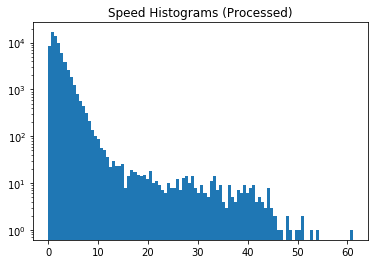

In [13]:
outs_mouse = [out_array[:,i:2*(i+1)] for i in range(2)]
speed_hists('Speed Histograms (Processed)',outs_mouse)

resetting filters...


(-1799.8000000000002, 37795.8, -15.88136228322983, 387.97393234968183)

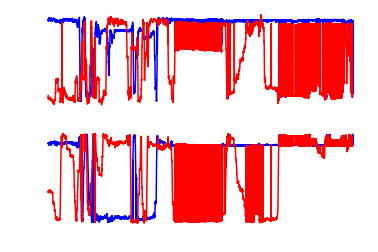

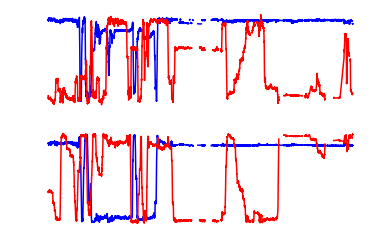

In [98]:
data[13].reset_filters([3,8])
rendered = data[13].render_trajectories([3])[0]
renderedm = data[13].render_trajectories([8])[0]


fig,ax = plt.subplots(2,1)
ax[0].plot(rendered[:,0:1],'blue')
ax[1].plot(rendered[:,1:2],'blue')
ax[0].plot(renderedm[:,0:1],'red')
ax[1].plot(renderedm[:,1:2],'red')
ax[0].axis('off')
ax[1].axis('off')

fig,ax = plt.subplots(2,1)
ax[0].plot(out_array[:,0:1],'blue')
ax[1].plot(out_array[:,1:2],'blue')
ax[0].plot(out_array[:,2:3],'red')
ax[1].plot(out_array[:,3:4],'red')
ax[0].axis('off')
ax[1].axis('off')

In [96]:
def interpolate_isnans(out_array):
    vgood,mgood = np.where(~np.isnan(out_array[:,0:1]))[0],np.where(~np.isnan(out_array[:,2:3]))[0]
    good_valsv,good_valsm = out_array[vgood,0:2],out_array[mgood,2:4]
    vinterp = interp1d(vgood,good_valsv,axis = 0,bounds_error = False,fill_value = 'extrapolate',kind = 'slinear')
    minterp = interp1d(mgood,good_valsm,axis = 0,bounds_error = False,fill_value = 'extrapolate',kind = 'slinear')
    return vinterp,minterp

vinterp,minterp = interpolate_isnans(out_array)

[[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [ True]]


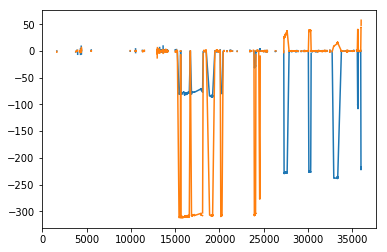

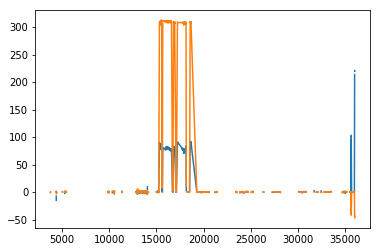

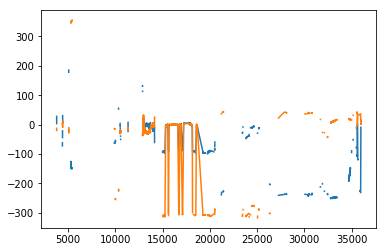

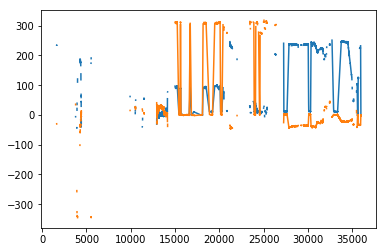

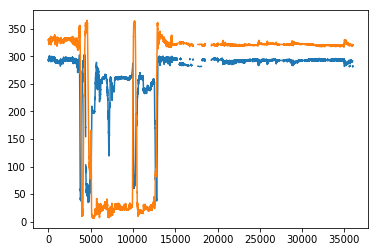

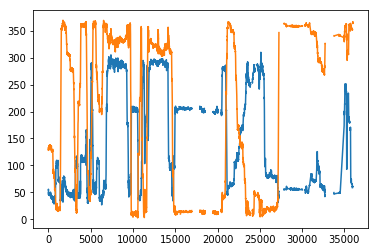

In [97]:
print(np.isnan(out_array[:,0:1]))
v_conf = trajectories[0][np.isnan(out_array[:,0:1])[:,0],:]
m_conf = trajectories[1][np.isnan(out_array[:,2:3])[:,0],:]

shell_array_2 = np.empty((36000,4))
shell_array_2[:] = np.nan

shell_array_2[np.isnan(out_array[:,0:1])[:,0],:2] = v_conf
shell_array_2[np.isnan(out_array[:,2:3])[:,0],2:] = m_conf

residualsmm = minterp(np.arange(36000))-shell_array_2[:,2:]
residualsvv = vinterp(np.arange(36000))-shell_array_2[:,:2]
residualsmv = minterp(np.arange(36000))-shell_array_2[:,:2]
residualsvm = vinterp(np.arange(36000))-shell_array_2[:,2:]

mm_redeemed = np.where(np.linalg.norm(residualsmm,axis = 1)<3)[0]
mv_redeemed = np.where(np.linalg.norm(residualsmv,axis = 1)<3)[0]
vv_redeemed = np.where(np.linalg.norm(residualsvv,axis = 1)<3)[0]
vm_redeemed = np.where(np.linalg.norm(residualsvm,axis = 1)<3)[0]


out_array[vm_redeemed,:2] = shell_array_2[vm_redeemed,2:]
out_array[vv_redeemed,:2] = shell_array_2[vv_redeemed,:2]
out_array[mv_redeemed,2:] = shell_array_2[mv_redeemed,:2]
out_array[mm_redeemed,2:] = shell_array_2[mm_redeemed,2:]

plt.plot(residualsmm)
plt.show()
plt.plot(residualsvv)
plt.show()
plt.plot(residualsmv)
plt.show()
plt.plot(residualsvm)
plt.show()
plt.plot(out_array[:,:2])
plt.show()
plt.plot(out_array[:,2:])
plt.show()



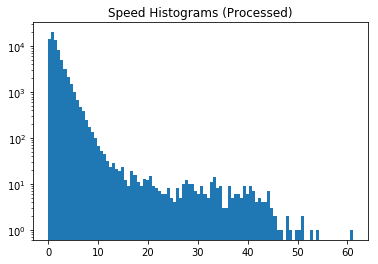

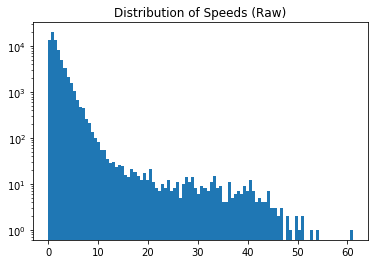

In [16]:
vinterp,minterp = interpolate_isnans(out_array)

outs_mouse = [vinterp(np.arange(36000)),minterp(np.arange(36000))]
speed_hists('Speed Histograms (Processed)',outs_mouse)

speed_hists('Distribution of Speeds (Raw)',trajectories)

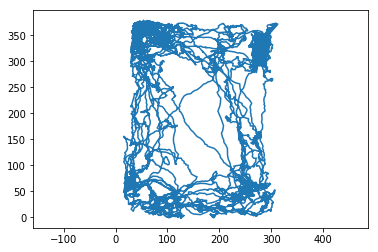

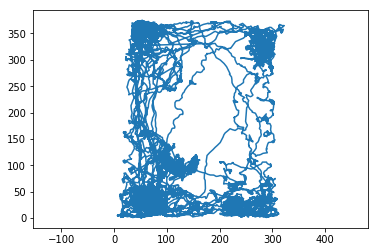

In [17]:
vtraj = vinterp(np.arange(36000))
mtraj = minterp(np.arange(36000))
plt.plot(vtraj[:,0],vtraj[:,1])
plt.axis('equal')
plt.show()
plt.plot(mtraj[:,0],mtraj[:,1])
plt.axis('equal')
plt.show()

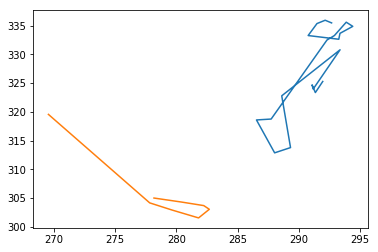

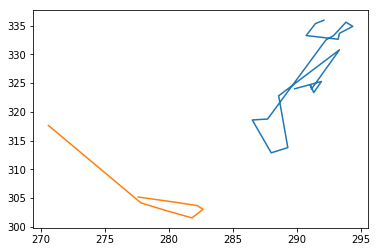

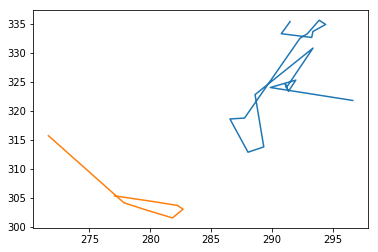

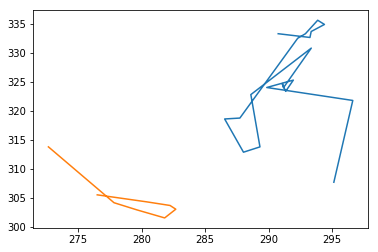

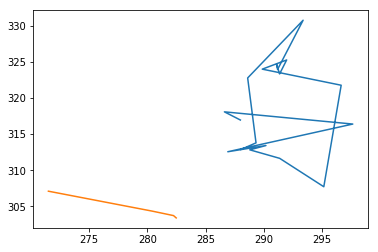

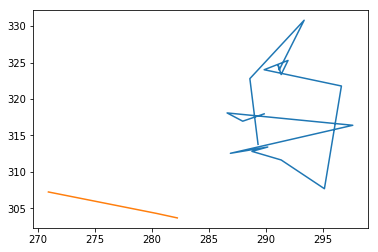

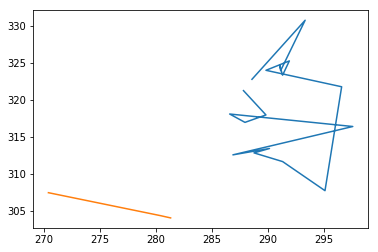

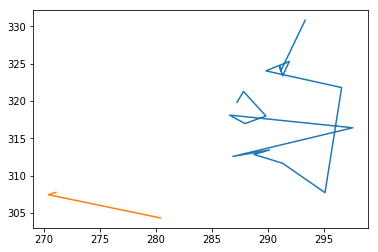

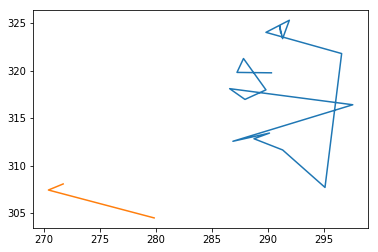

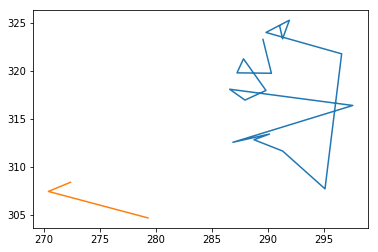

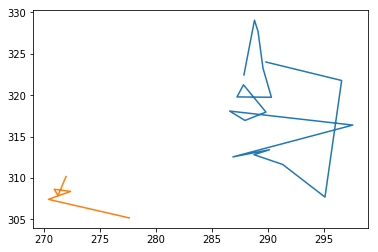

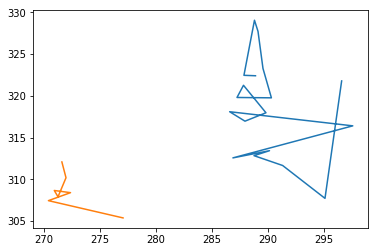

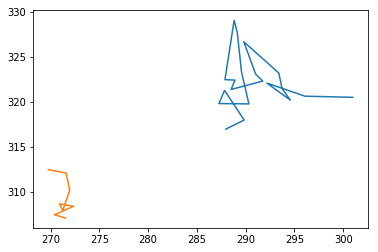

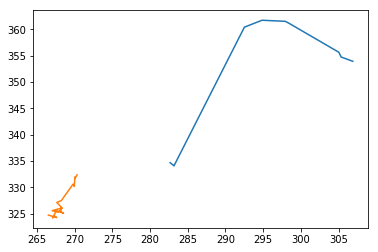

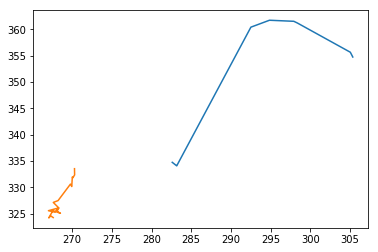

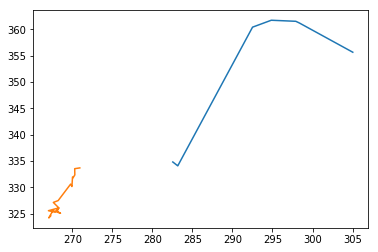

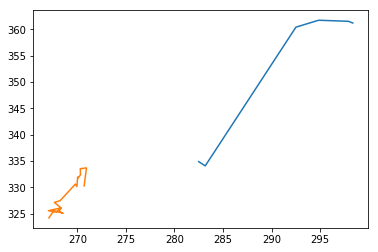

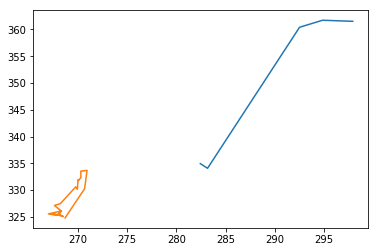

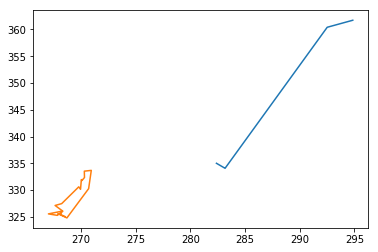

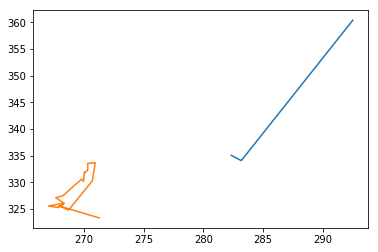

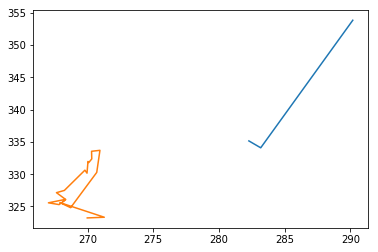

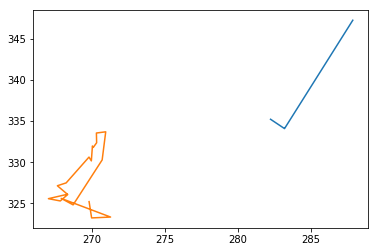

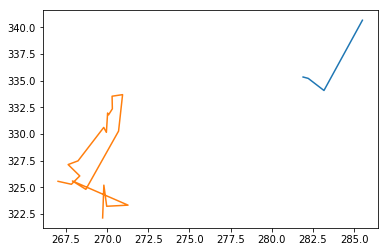

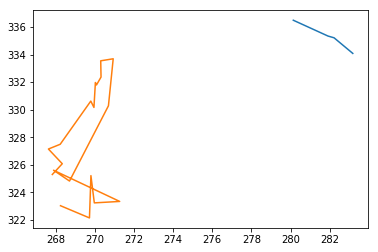

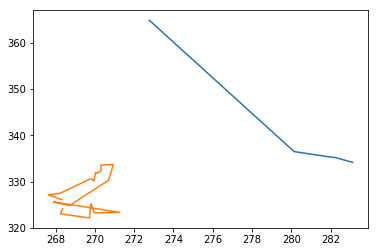

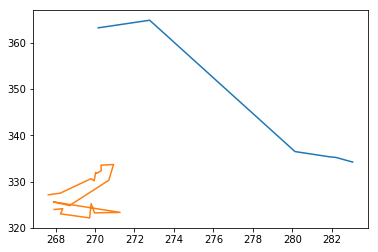

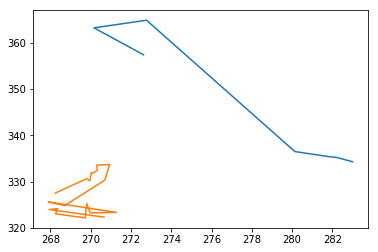

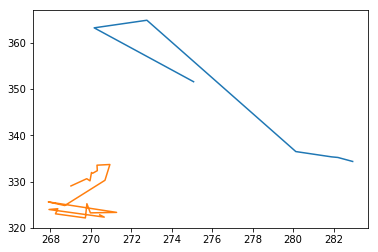

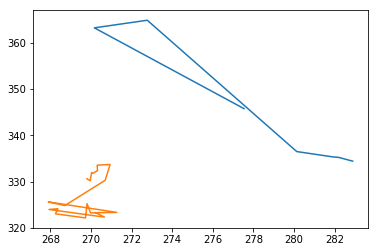

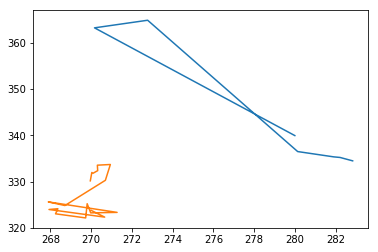

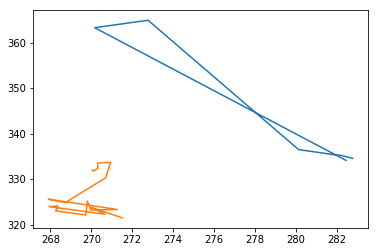

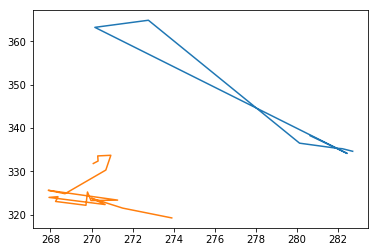

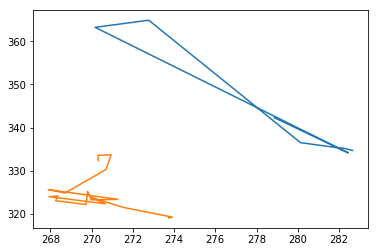

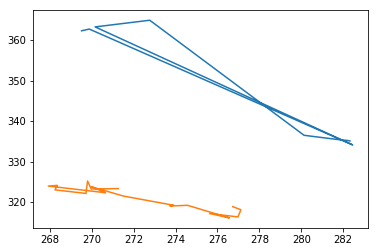

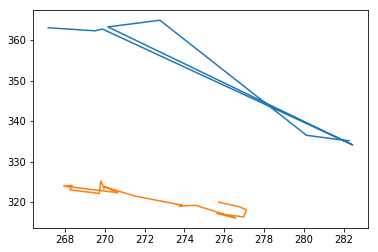

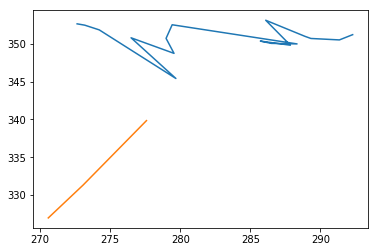

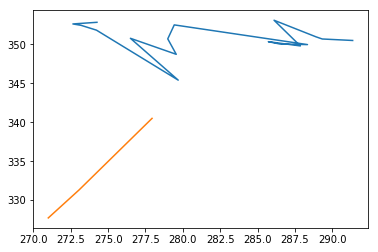

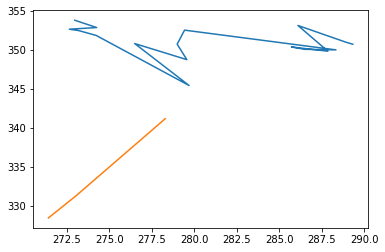

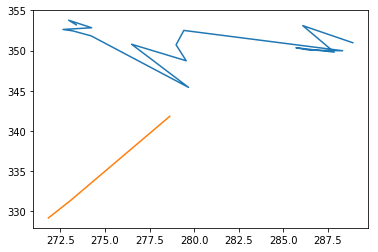

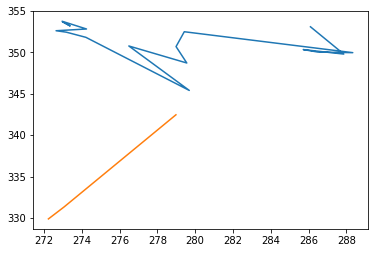

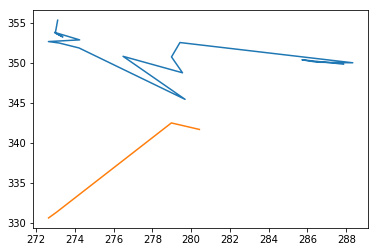

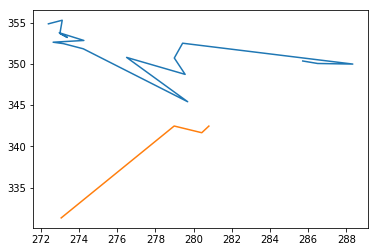

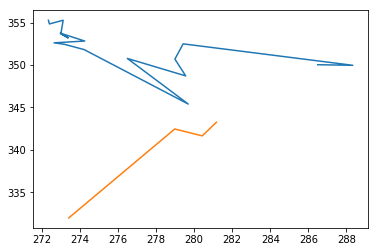

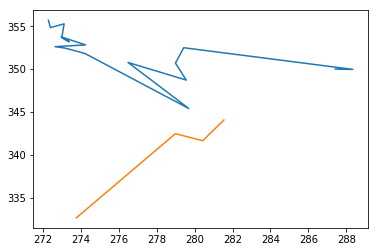

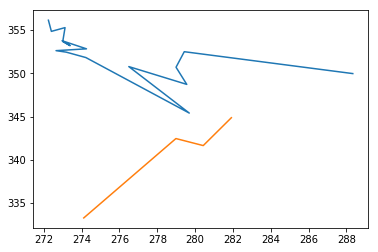

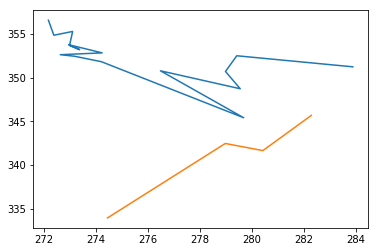

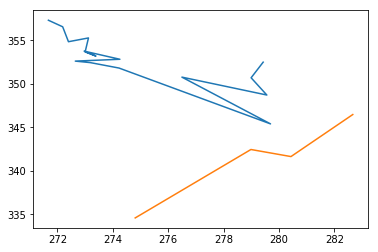

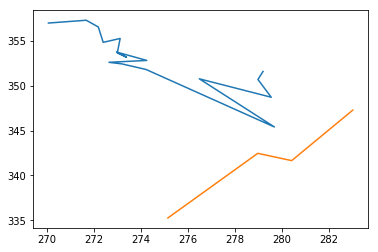

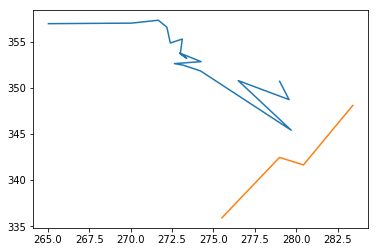

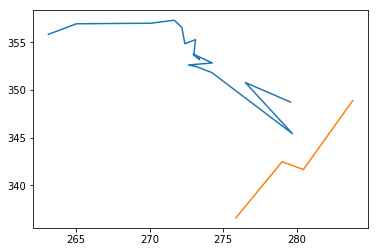

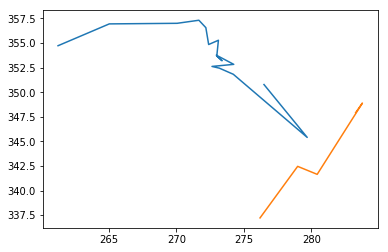

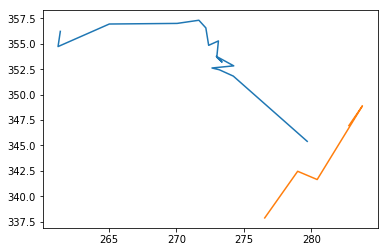

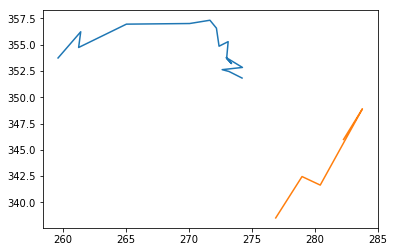

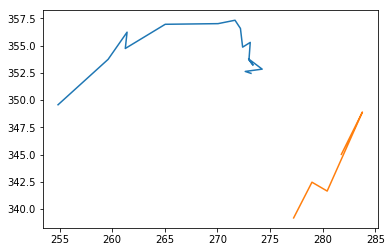

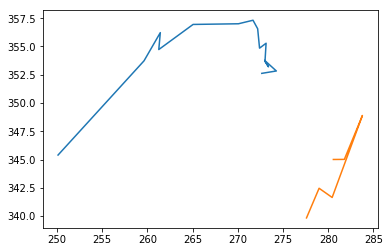

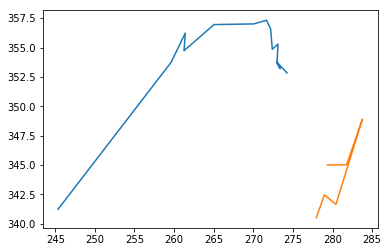

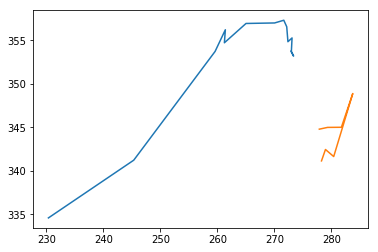

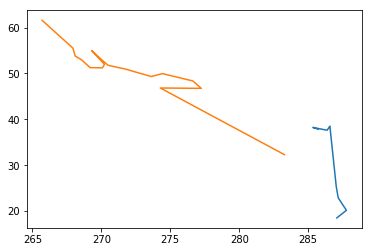

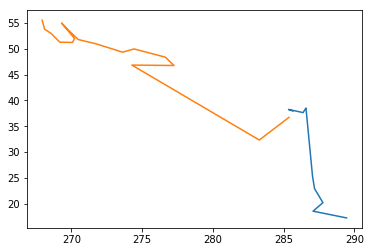

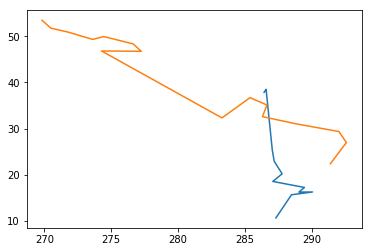

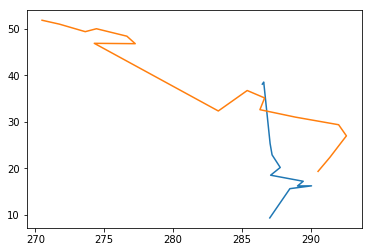

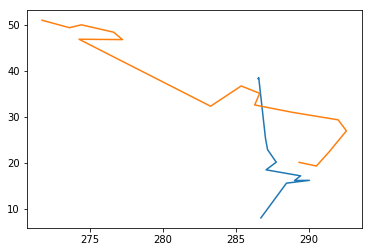

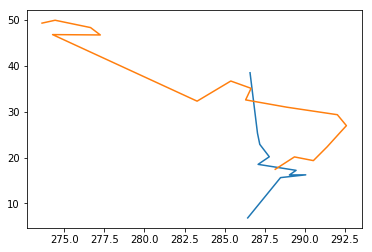

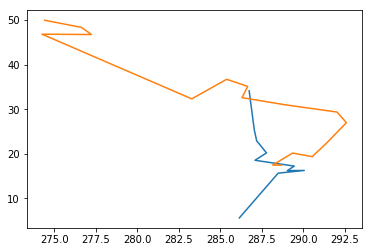

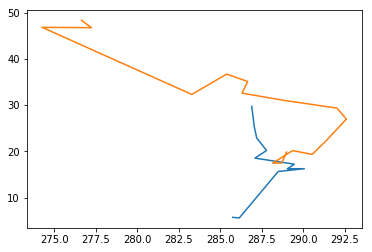

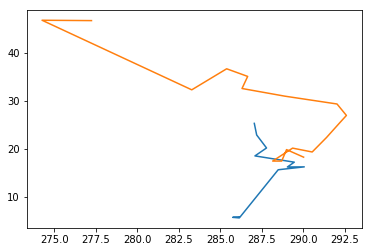

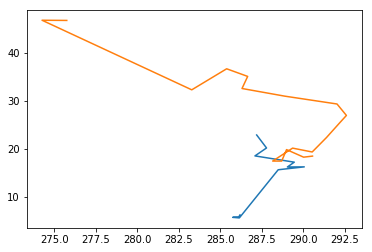

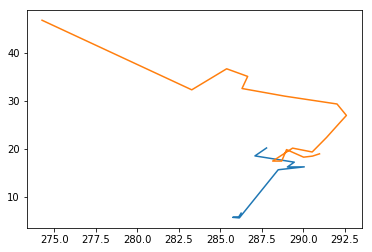

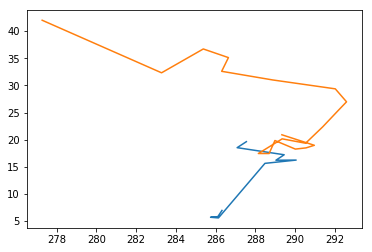

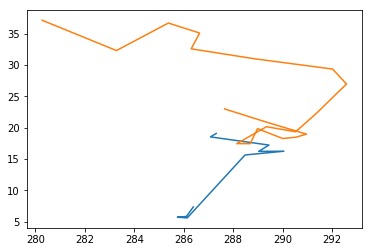

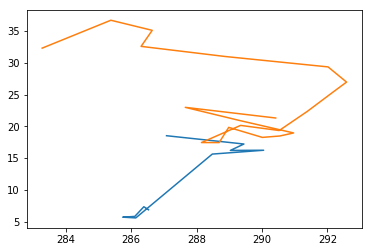

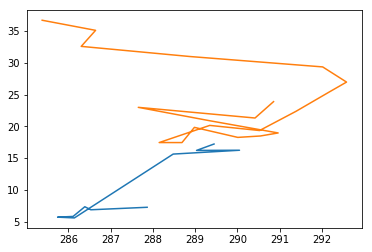

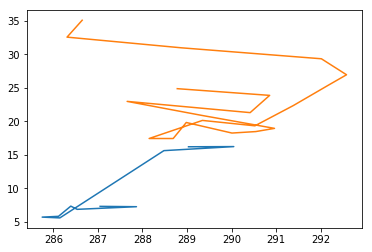

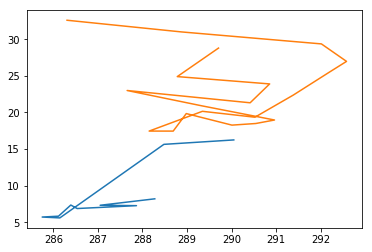

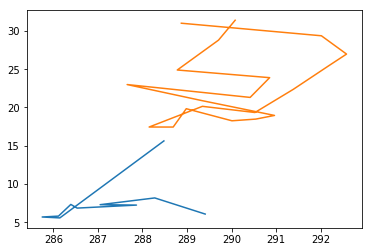

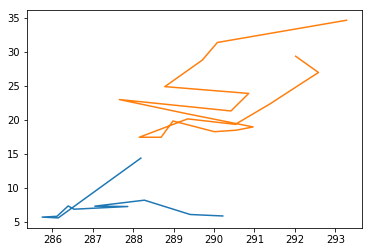

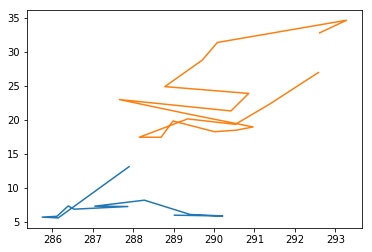

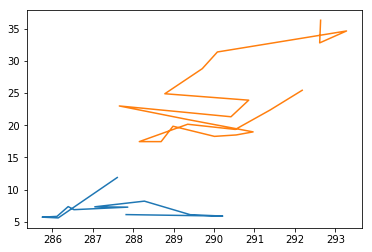

KeyboardInterrupt: 

In [18]:
locs = np.where(np.linalg.norm(mtraj-vtraj,axis = 1)<20)[0]
for loc in locs:
    plt.plot(mtraj[loc-10:loc+10,0],mtraj[loc-10:loc+10,1])
    plt.plot(vtraj[loc-10:loc+10,0],vtraj[loc-10:loc+10,1])
    plt.show()

In [ ]:
## Write an extrapolation function that extrapolates forwards: 
def extrapolatef(x_p,f_p,x_extrap,var=1):
    #Find the slope:
    # Assume both rise and run are 2 by 2:
    run = x_p[-1]-x_p[0]
    rise = f_p[-1]-f_p[0]
    slope = rise/run
    extrap_run = x_extrap - x_p[-1]  
    print(rise,extrap_run*slope,x_p)
    new_point = f_p[-1] + slope*extrap_run

    return new_point,var*extrap_run

def extrapolateb(x_p,f_p,x_extrap,var=1):
    #Find the slope:
    # Assume both rise and run are 2 by 2:
    run = x_p[-1]-x_p[0]
    rise = f_p[0]-f_p[-1]
    slope = rise/run
    extrap_run = x_p[0] - x_extrap  
    print(rise,extrap_run*slope,x_p)
    new_point = f_p[0] + slope*extrap_run

    return new_point,var*extrap_run

In [ ]:
a = np.random.randn(2,2)

In [ ]:
x_p = np.array([0,2])

x_extrap = -5

In [ ]:
extrapolate(x_p,a,x_extrap)

In [ ]:
plt.plot(x_p,a)
plt.plot(x_extrap,extrapolateb(x_p,a,x_extrap)[0][None,:],'o')
# plt.plot(x_extrap,extrapolateb(x_p,a,-x_extrap)[1][None,:],'_')
# plt.plot(x_extrap,extrapolateb(x_p,a,-x_extrap)[2][None,:],'_')

In [ ]:
inds,vals,xind = (np.array([19311, 19312]), np.array([[179.02281201,  20.003471  ],[161.89173889,  21.01497388]]), 19287)

In [ ]:
plt.plot(inds,vals)
plt.plot(xind,extrapolateb(inds,vals,xind)[0][None,:],'o')

In [ ]:
# We want the form: [index,part number]:
# This is best represented by having part indices in an array of zeros: 
z = np.zeros((10,2))
z[0,0:1] = 2
z[3,0:1] = 2
z[6,1:2] = 5

In [ ]:
for i in range(z.shape[1]):
    col = z[:,i]
    good = np.where(col!=0)[0][:,None]
    col[good]
    out = np.concatenate((good,col[good]),axis = 1)
    print(out)

## Translating everything to class code:


In [ ]:
np.isnan(out_array[500:600,0:1])[:,0]

In [22]:
mm_redeemed

array([   27,    28,    29, ..., 35983, 35984, 35999])

In [23]:
vm_redeemed

array([23245, 23246, 27861, 31177, 31178])

In [24]:
vv_redeemed

array([ 1150,  1151,  1153,  1154,  1155,  1157,  1168,  1191,  1192,
        1195,  1196,  1197,  1220,  1225,  1298,  1300,  1301,  1303,
        1304,  1305,  1309,  1310,  1311,  1317,  1320,  1321,  1322,
        1362,  1363,  1365,  1368,  1537,  1538,  8607,  8608,  8609,
        8610,  8611, 12005, 12006, 12007, 12321, 12322, 12323, 12324,
       12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333,
       12594, 12595, 12610, 12611, 12612, 12691, 12708, 12709, 12722,
       12726, 12727, 12728, 12743, 13042, 13043, 13760, 13761, 14518,
       16101, 16102, 17000, 17001, 17034, 17035, 17043, 17044, 17045,
       17047, 17049, 17050, 17140, 17141, 17143, 17144, 17148, 17149,
       17650, 17651, 17653, 18507, 18508, 18509, 18510, 18511, 18512,
       18513, 18592, 18593, 18594, 18595, 18596, 18684, 19320, 19321,
       19322, 19341, 19342, 19405, 20122, 20123, 20124, 20126, 20128,
       20253, 20254, 20263, 20264, 20723, 20724, 20736, 20737, 20742,
       20743, 20744,

In [13]:
#We need to recreate: 
#- find_segments
#- segment_getter
#- classify_v3
compare_array = doi.filter_segment(0)

 53%|█████▎    | 18958/36000 [00:00<00:00, 35504.39it/s]

(302.1676860024336, 21.314581443356758, 15662)
(306.9309483757868, 43.520431578826745, 16620)


100%|██████████| 36000/36000 [00:00<00:00, 37267.90it/s]


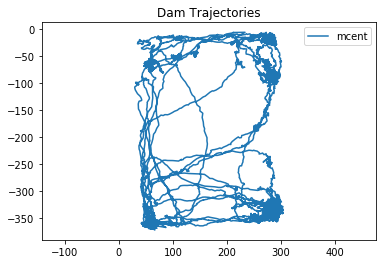

In [106]:
doi.plot_trajectory([8])

In [103]:
np.where(np.isnan(out))

NameError: name 'out' is not defined

((35999, 2), (36000, 2))
((35999, 2), (36000, 2))


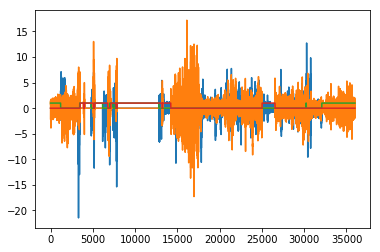

In [107]:
smoothed0 = doi.relative_speed(0)
# smoothed0[abs(smoothed0)>10]= np.nan
smoothed1 = doi.relative_speed(1)
# smoothed1[abs(smoothed1)>10]= np.nan
doi.bounds = (250,260)
plt.plot(smoothed0[:]*~doi.nest_ethogram(0)[:-1])
plt.plot(smoothed1[:]*~doi.nest_ethogram(1)[:-1])

plt.plot(doi.nest_ethogram(0))
plt.plot(doi.nest_ethogram(1))

[MoviePy] >>>> Building video new_shepevents.mp4
[MoviePy] Writing video new_shepevents.mp4




  0%|          | 0/1113 [00:00<?, ?it/s]

  4%|▎         | 39/1113 [00:00<00:02, 387.96it/s]

  7%|▋         | 74/1113 [00:00<00:03, 335.02it/s]

 10%|█         | 115/1113 [00:00<00:03, 319.65it/s]

 14%|█▍        | 157/1113 [00:00<00:02, 343.27it/s]

 17%|█▋        | 184/1113 [00:00<00:03, 306.90it/s]

 20%|██        | 228/1113 [00:00<00:02, 336.35it/s]

 23%|██▎       | 260/1113 [00:00<00:02, 310.44it/s]

 26%|██▌       | 290/1113 [00:00<00:02, 289.47it/s]

 29%|██▊       | 319/1113 [00:01<00:02, 277.17it/s]

 31%|███       | 347/1113 [00:01<00:02, 269.46it/s]

 34%|███▎      | 374/1113 [00:01<00:02, 260.95it/s]

 36%|███▌      | 400/1113 [00:01<00:03, 216.09it/s]

 38%|███▊      | 427/1113 [00:01<00:03, 221.46it/s]

 42%|████▏     | 468/1113 [00:01<00:02, 239.60it/s]

 46%|████▌     | 510/1113 [00:01<00:02, 274.88it/s]

 49%|████▉     | 546/1113 [00:01<00:01, 295.23it/s]

 52%|█████▏    | 578/1113 [00:02<00:02, 261.62it/s]

 55%|█████▍    | 607/1113 [00:02<00:01, 269.23it/s]

 58%

IOError: MoviePy error: failed to read the first frame of video file ../../Downloads/V118_03182018_cohousing-Camera-1-Animal-1-Segment1cropped_part9.mp4. That might mean that the file is corrupted. That may also mean that you are using a deprecated version of FFMPEG. On Ubuntu/Debian for instance the version in the repos is deprecated. Please update to a recent version from the website.

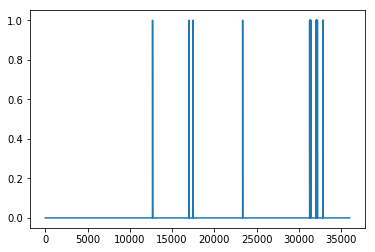



 98%|█████████▊| 1086/1113 [00:20<00:00, 266.54it/s]

In [79]:
plt.plot(doi.shepherding_ethogram())
path = '../../Downloads/V118_03182018_cohousing-Camera-1-Animal-1-Segment1cropped_part'
doi.import_movie(path+'9.mp4')
doi.highlights_reel('new_shepevents',onehot*(~not_innest)*close,buffer = 20)

In [ ]:
np.where(out_array[:,0])[0]

In [ ]:
np.where(compare_array[:,0])[0]

In [ ]:
plt.plot(np.isnan(out_array[5000:,3]))
plt.plot(~np.isnan(compare_array[5000:,0]))

In [ ]:
v_segs

In [ ]:
from Social_Dataset_Class import interpolate_isnans

In [ ]:
vinterp(10000)

In [ ]:
m_conf

In [ ]:
plt.plot(np.isnan(compare_array[:,1]))

In [ ]:
plt.plot(np.isnan(out_array[:,2]))

In [77]:
onehot = [ i in np.where(smoothed0>3)[0] for i in range(36000)]
not_innest = doi.nest_ethogram(0)

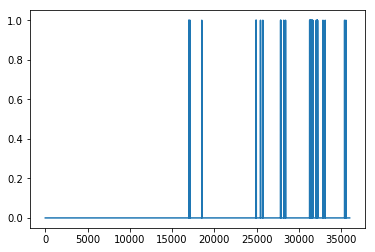

In [78]:
plt.plot(onehot*(~not_innest)*close)

In [75]:
close = [dist < 50 for dist in doi.proximity()]

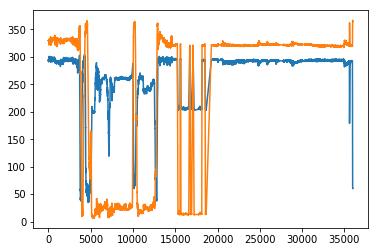

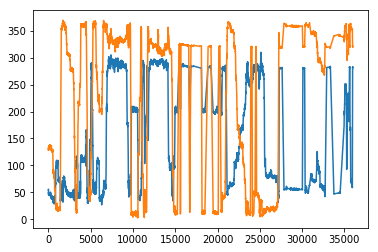

In [10]:
plt.plot(doi.render_trajectories([3])[0])
plt.show()
plt.plot(doi.render_trajectories([8])[0])

In [125]:
start = 7700
end = 7900
data_29_inds = [i in np.arange(end-start)+start for i in range(36000)]

In [126]:
data[29].highlights_reel('event29_7',data_29_inds)

[MoviePy] >>>> Building video event29_7.mp4
[MoviePy] Writing video event29_7.mp4


100%|██████████| 212/212 [00:00<00:00, 272.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: event29_7.mp4 



Define $x^{(p)}_{t}$, position of body part (p) at time (t)

$f_{spl}(x_t;x_{t'})$ gives the spline 
interpolant at $x_t$, centered at $x_{t'}$


$
    V(t,t')= 
\begin{cases}
     1,& \text{if } \|x_t-f_{spl}(x_t;x_{t'})\|_{\infty}<T \\
    -1,& \text{if } \|x_t-f_{spl}(x_t;x_{t'})\|_{\infty}\geq T 
\end{cases}
$

$
    \bar{x}_{t}= 
\begin{cases}
     x_{t},& \text{if } \sum_{t'}V(t,t') >0 \\
     \_,& \text{if } \sum_{t'}V(t,t') \leq 0
\end{cases}
$


Define P_{p} the set of body part i.d.s given to animal with part p

Define $p'$ the analog of $p$ in $\lnot P_{p}$

Define $\sigma_{p,q}$ standard deviation of distance between labeled $p,q$

 ($\sigma_{p,p'}$ is a parameter)

$
    A_{t}(p,q)= 
\begin{cases}
     \|x_{t}^{p}-x_{t}^{q}\| <2*\sigma_{p,q'},& \text{if } p \neq q \\
     0,& \text{if } p = q
\end{cases}
$

$
    \bar{x}_{t}= 
\begin{cases}
     x_{t},& \text{if } \sum_{q\in P_{p}}A_{t}(p,q) -\sum_{q\in \lnot P_{p}}A_{t}(p,q)>0 \\
     \_,& \text{if } \sum_{q\in P_{p}}A_{t}(p,q) -\sum_{q\in \lnot P_{p}}A_{t}(p,q)\leq0
\end{cases}
$




Isolate contiguous segments of $\bar{x}_t$:

In [165]:
data[0].adjacency_matrix([19550],vstats,mstats,[2,2])[0]

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 1., 1., 0.]])

In [144]:
data[0].import_movie(path+'0.mp4')

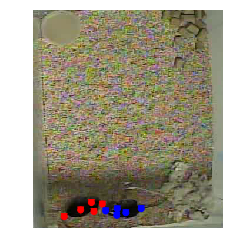

In [163]:
data[0].plot_image_compare([0,1,2,3,4,5,6,7,8,9],19550)